# SANS: Using CNN to predict model ID
We will utilize the zenodo [repository](https://zenodo.org/records/10119316) as our data for this project. There is no need to locally download the data as we will be using the library `fsspec` to work directly with the link of the `.h5` files. This will not load the data from the remote files into the user's working memory.

In [1]:
import h5py
import fsspec
import torch
import pickle
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

## load data

In [2]:
url = "https://zenodo.org/records/10119316/files/train.h5"
remote_f = fsspec.open(url, mode="rb")
if hasattr(remote_f, "open"):
    remote_f = remote_f.open()
#f = h5py.File(remote_f)
#f.visititems(print)

In [3]:
class H5Dataset(Dataset):
    def __init__(self, h5_path, transforms=None):
        self.h5_file = h5py.File(h5_path, "r")
        self.transform = transforms

    def __getitem__(self, index):
        sample = self.h5_file["data"][index]
        if self.transform is not None:
            sample = self.transform(sample)
        return (
            sample,
            int(self.h5_file["target"][index]),
        )

    def __len__(self):
        return self.h5_file["target"].size

In [ ]:
transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((180, 180), antialias=True),
        torch.nn.ReLU(inplace=True),  # remove negative values if any
        torchvision.transforms.Lambda(lambda x: torch.log(x + 1.0)),
        torchvision.transforms.Lambda(
            lambda x: x / torch.max(x) if torch.max(x) > 0 else x
        ),
    ]
)
train_data = H5Dataset(remote_f)


181531

In [5]:
len(train_data)
train_data[0]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 11)

### Plotting a typical 2D intensity array

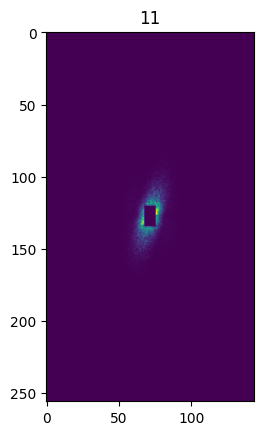

In [6]:
idx = 0
psd_array = train_data[idx][0]
target = train_data[idx][1]
plt.figure()
plt.imshow(psd_array)
plt.title(target)
plt.show()

### exploring the model names

Manually add the `.pkl` files inside the directory `sas_helper/` as some of the files are too large to be uploaded on a GitHub repo. These files have been purposefully added to `.gitignore` due to this reason.

In [ ]:
with open("sas_helper/model_names.pkl", "rb") as pf:    # 
    model_names = pickle.load(pf)
print(model_names)

{0: 'Adsorbed layer', 1: 'Barbell aniso', 2: 'Bcc paracrystal aniso', 3: 'Binary hard sphere', 4: 'Broad peak', 5: 'Capped cylinder aniso', 6: 'Core shell bicelle aniso', 7: 'Core shell bicelle elliptical aniso', 8: 'Core shell bicelle elliptical belt rough aniso', 9: 'Core shell cylinder aniso', 10: 'Core shell ellipsoid aniso', 11: 'Core shell parallelepiped aniso', 12: 'Core shell sphere', 13: 'Cylinder aniso', 14: 'Dab', 15: 'Ellipsoid aniso', 16: 'Elliptical cylinder aniso', 17: 'Fcc paracrystal aniso', 18: 'Flexible cylinder', 19: 'Fractal', 20: 'Fractal core shell', 21: 'Fuzzy sphere', 22: 'Gauss lorentz gel', 23: 'Gel fit', 24: 'Hollow cylinder aniso', 25: 'Hollow rectangular prism aniso', 26: 'Lamellar hg', 27: 'Lamellar hg stack caille', 28: 'Lamellar stack paracrystal', 29: 'Mass fractal', 30: 'Mono gauss coil', 31: 'Multilayer vesicle', 32: 'Parallelepiped aniso', 33: 'Pearl necklace', 34: 'Poly gauss coil', 35: 'Polymer micelle', 36: 'Raspberry', 37: 'Rectangular prism ani

In our case, model ID = 11, the model name is given as

In [9]:
model_names[11]

'Core shell parallelepiped aniso'

### pytorch dataloader

Here is a code template you could use to put this dataset in a dataloader for `pytorch`, which could directly go in a training loop.

In [10]:
val_dataloader = DataLoader(
    train_data,
    batch_size=32, # play with this also
    num_workers=2, #modify to your cpus available!
    shuffle=True,
)

### loading instrument parameters

In [12]:
inst_params = {}
for partition in ["test", "train", "val"]:
    with open(f"sas_helper/inst_params_{partition}.pkl", "rb") as pf:
        inst_params[partition] = pickle.load(pf)

In [14]:
inst_params['train'].shape

torch.Size([181531, 10])

In [15]:
inst_params['train'][0]

tensor([0., 1., 0., 1., 1., 0., 0., 1., 0., 0.])

We loaded all the instrument parameters inside the `inst_params` dictionary, with the corresponding partition as key. The 10 parameters that are one-hot encoded are:

In [16]:
inst_params_names  = ['Lam_4.5', 'Lam_6.0', 'zdepth_0.001', 'zdepth_0.002', 'InstSetting_1', 'InstSetting_2', 'InstSetting_3', 'SlitSetting_1', 'SlitSetting_2', 'SlitSetting_3']
print(inst_params_names)

['Lam_4.5', 'Lam_6.0', 'zdepth_0.001', 'zdepth_0.002', 'InstSetting_1', 'InstSetting_2', 'InstSetting_3', 'SlitSetting_1', 'SlitSetting_2', 'SlitSetting_3']


- Lam = Lambda, wavelength of monochromatized neutrons in Angstroms. Two possible values [4.5, 6.0]
- zdepth = sample thickness, Two possible values [0.001, 0.002]
- InstSetting = Instrument setting. 3 possible values [1, 2, 3]
- SlitSetting = slit (collimation) setting, 3 possible values [1, 2, 3]

Again, variables are one hote encoded. Order of columns matters. This means that case 0 (described above) was measured with a wavelength of 4.5, a sample thickness of 0.001, and a slit setting of 2. (check)

This matrix can be used as **input features** for the regression or classification task.


## model